In [10]:
# FILE UPLOAD
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=filename, length=len(uploaded[filename])))


Saving server_outputFIFOc.txt to server_outputFIFOc.txt
Saving server_outputSJNc.txt to server_outputSJNc.txt
User uploaded file "server_outputFIFOc.txt" with length 269103 bytes
User uploaded file "server_outputSJNc.txt" with length 161335 bytes


**Part A:**
I ran the command given 10 times for both FIFO and SJN. I retrieved the elapsed wall clock times as instructed. The hard coded in the twenty times that I collected and then the remainder of the code below computes the averages for both FIFO and SJN. I then repeated for high utilization.

The **low** utilization averages that were calculated:
Average time for FIFO: 2:33.21
Average time for SJN: 2:33.50

The **high** utilization averages that were calculated:
Average time for FIFO: 0:39.97
Average time for SJN: 0:39.71

Taking a look at my results, SJN offers a minor performance benefit under high utilization. However, the choice between FIFO and SJN might not drastically impact performance at least in this specific scenario.

In [2]:
def convert_to_seconds(time_string):
    minutes, seconds = map(float, time_string.split(':'))
    return 60 * minutes + seconds

def compute_average(time_list):
    return sum(time_list) / len(time_list)

def convert_to_mins_secs(seconds):
    mins = int(seconds // 60)
    secs = seconds % 60
    return f"{mins}:{secs:0.2f}"

# FIFO and SJN times
fifo_times_lowutil = ["2:33.11", "2:32.10", "2:34.11", "2:32.40", "2:32.71", "2:33.63", "2:32.20", "2:33.60", "2:33.92", "2:34.31"]
sjn_times_lowutil = ["2:32.70", "2:34.25", "2:32.79", "2:35.66", "2:34.45", "2:32.61", "2:34.25", "2:32.76", "2:32.37", "2:33.12"]
fifo_times_highutil = ["0:39.23", "0:39.59", "0:41.38", "0:40.07", "0:40.16", "0:39.57", "0:40.75", "0:39.43", "0:40.31", "0:39.22"]
sjn_times_highutil = ["0:39.91", "0:39.66", "0:40.21", "0:40.40", "0:39.41", "0:39.36", "0:39.51", "0:39.76", "0:39.32", "0:39.60"]

# Convert times to seconds
fifo_seconds = [convert_to_seconds(time) for time in fifo_times_highutil]
sjn_seconds = [convert_to_seconds(time) for time in sjn_times_highutil]

# Compute averages
fifo_avg = compute_average(fifo_seconds)
sjn_avg = compute_average(sjn_seconds)

# Convert averages to m:ss format
fifo_avg_mins_secs = convert_to_mins_secs(fifo_avg)
sjn_avg_mins_secs = convert_to_mins_secs(sjn_avg)

print(f"Average time for FIFO: {fifo_avg_mins_secs}")
print(f"Average time for SJN: {sjn_avg_mins_secs}")


Average time for FIFO: 0:39.97
Average time for SJN: 0:39.71


**Part B:**
I ran the commands as directed, writing the output to two text files. I uploaded those two text files here and the code below parses + plots the data.

The plot below clearly shows that SJN exhibits far better peerformance than FIFO. Throughout the range of server utilization values, the average response time for SJN is consistently lower than that of FIFO. This indicates that SJN is more efficient in handling requests compared to FIFO.

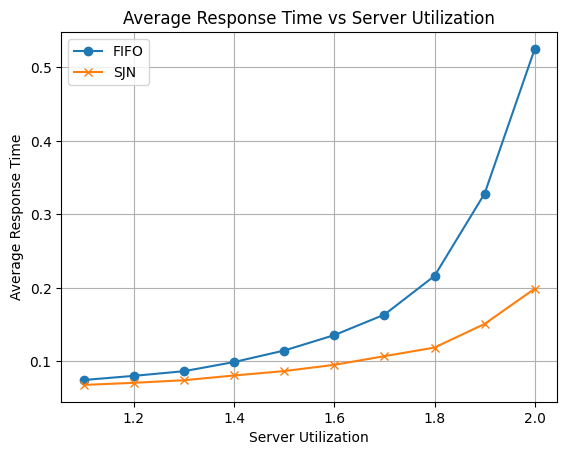

In [5]:
import matplotlib.pyplot as plt

def extract_response_times(file_path):
    response_times = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Checking if the line starts with a thread identifier like T0, T1, ...
            if line.startswith("T"):
                parts = line.split(",")
                sent_time = float(parts[0].split(":")[-1])  # Extracting the sent time after the colon
                completion_time = float(parts[-1])  # Last value in the split is the completion time
                response_time = completion_time - sent_time
                response_times.append(response_time)

    return response_times

def calculate_average_response_times_for_experiments(file_path):
    all_response_times = extract_response_times(file_path)
    avg_response_times = []
    num_requests = 1500

    for i in range(0, len(all_response_times), num_requests):
        avg_response_time = sum(all_response_times[i:i+num_requests]) / num_requests
        avg_response_times.append(avg_response_time)

    return avg_response_times

# Extracting data for both FIFO and SJN
avg_response_times_FIFO = calculate_average_response_times_for_experiments("server_outputFIFO.txt")
avg_response_times_SJN = calculate_average_response_times_for_experiments("server_outputSJN.txt")

# Computing server utilization for the experiments
utilization = [i / 20 for i in range(22, 41, 2)]

# Plotting the results
plt.plot(utilization, avg_response_times_FIFO, marker='o', label='FIFO')
plt.plot(utilization, avg_response_times_SJN, marker='x', label='SJN')
plt.title('Average Response Time vs Server Utilization')
plt.xlabel('Server Utilization')
plt.ylabel('Average Response Time')
plt.legend()
plt.grid(True)
plt.show()

**Part C:**
The code below produces the requested plot of both FIFO and SJN CDFs.

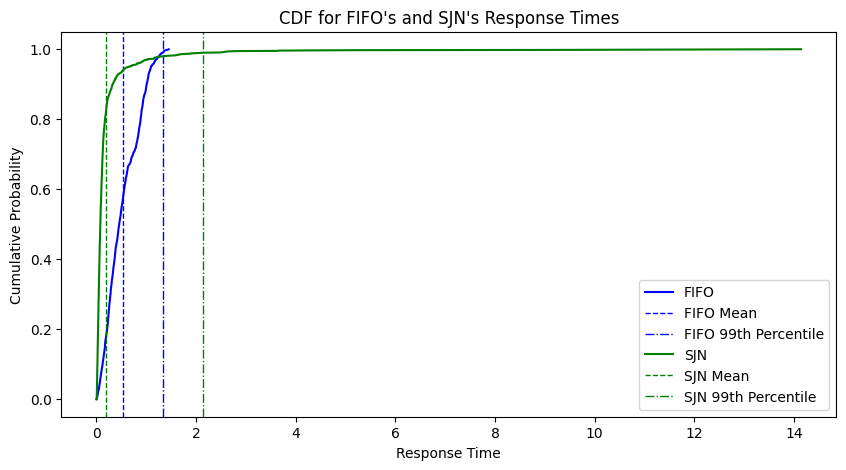

In [14]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Read the FIFO data
with open('server_outputFIFOc.txt', 'r') as f:
    fifo_content = f.readlines()

# Read the SJN data
with open('server_outputSJNc.txt', 'r') as f:
    sjn_content = f.readlines()

# Define a function to extract the response times from the file's content
def extract_response_times(content):
    # Regular expression pattern to match lines with response times
    pattern = r'T\d+ R\d+:(\d+\.\d+),(\d+\.\d+),(\d+\.\d+),(\d+\.\d+),(\d+\.\d+)'
    response_times = []
    for line in content:
        match = re.match(pattern, line)
        if match:
            sent_time, _, _, _, completion_time = map(float, match.groups())
            response_times.append(completion_time - sent_time)
    return response_times

# Extract the response times
fifo_data = extract_response_times(fifo_content)
sjn_data = extract_response_times(sjn_content)

# Plotting function for the CDF
def plot_cdf(data, label, color):
    if not data:
        print(f"No response time data found for {label}")
        return
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, color=color, label=label)
    plt.axvline(np.mean(data), color=color, linestyle='dashed', linewidth=1, label=f"{label} Mean")
    plt.axvline(np.percentile(data, 99), color=color, linestyle='dashdot', linewidth=1, label=f"{label} 99th Percentile")

# Plot the CDF for FIFO and SJN
plt.figure(figsize=(10, 5))
plot_cdf(fifo_data, 'FIFO', 'blue')
plot_cdf(sjn_data, 'SJN', 'green')
plt.title("CDF for FIFO's and SJN's Response Times")
plt.xlabel("Response Time")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()


**Part D:**
First, to address the differences between the two CDFs -
FIFO: The CDF for FIFO is steeper and shifted to the left compared to SJN. This means that the response times for most tasks are quicker in FIFO.
SJN: The CDF for SJN is more spread out and lies to the right. This means that SJN has longer response times for a significant proportion of tasks.

From the graph and my analysis, I think it's evident that FIFO has a more predictable system behavior in terms of response times. The consistent range of response times in FIFO ensures that one can anticipate system behavior more prcisely than with SJN.

SJN can optimize for shorter tasks and sometimes yield lower average wait times, its overall predictability is damaged by the variance in response times. FIFO offers more consistent and thus more predictable response times, making it the more predictable system in this context.